In [ ]:
# !pip install -U pymilvus
# !pip install -U dreamsim
# !pip install -U setuptools

In [1]:
import os
import random
import numpy as np
from PIL import Image
from itertools import accumulate
import torch
from pathlib import Path
from torchvision import models, transforms

# pymilvus のORM用モジュールとutilityをインポート
from pymilvus import connections, Collection, FieldSchema, CollectionSchema, DataType, utility

# --- Milvusへの接続確立 ---
connections.connect("default", uri="./milvus_demo.db")

# --- コレクションの作成 ---
collection_name = "image_embeddings"

# 既存のコレクションが存在する場合は削除
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)

# コレクションスキーマに "embedding" と "file_path" フィールドを定義
fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=2048),
    FieldSchema(name="file_path", dtype=DataType.VARCHAR, max_length=256)
]
schema = CollectionSchema(fields, description="画像埋め込みコレクション (Image Embedding Collection)")

# コレクションの作成
collection = Collection(name=collection_name, schema=schema)

# --- インデックス作成 ---
index_params = {
    "index_type": "IVF_FLAT",   # 倒立ファイルフラット
    "metric_type": "COSINE",      # コサイン類似度
    "params": {"nlist": 128}
}
collection.create_index(field_name="embedding", index_params=index_params)

# --- 画像特徴抽出器の設定 ---
# torchvisionのResNet50（レズネット50）を利用（全結合層をIdentityに変更して2048次元出力に）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # fc層を除去
model.eval()
model.to(device)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def extract_feature(image_path):
    """画像パスから画像を読み込み、ResNet50で特徴ベクトルを抽出しL2正規化する関数"""
    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(img_tensor)
    feature_np = feature.cpu().numpy().flatten()
    norm = np.linalg.norm(feature_np)
    if norm > 0:
        feature_np = feature_np / norm
    return feature_np

# --- 画像データの登録 ---
# pathlibを使って実装(".jpg", ".jpeg", ".png"のファイルを対象)
image_dir = Path("../../sample_data/")
image_file_paths = [str(f) for f in list(image_dir.glob("**/*")) if f.suffix.lower() in (".jpg", ".jpeg", ".png")]

rows = []  # 行単位で挿入するリストを作成
for image_file_path in image_file_paths:
    try:
        feat = extract_feature(image_file_path)
        # 各行は辞書形式で "embedding" と "file_path" の両方を持たせる
        rows.append({
            "embedding": feat.tolist(),
            "file_path": image_file_path
        })
    except Exception as e:
        print(f"Error{image_file_path}: {e}")

# 行単位でデータを挿入
collection.insert(rows)
collection.flush()  # 挿入完了を保証



/home/kenta/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kenta/miniforge3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Error../../sample_data/corrupted_image/sample_corrupted_jpg.jpg: cannot identify image file '../../sample_data/corrupted_image/sample_corrupted_jpg.jpg'
Error../../sample_data/corrupted_image/sample_png.png: cannot identify image file '../../sample_data/corrupted_image/sample_png.png'


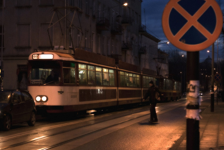

検索結果: 一致度： 1.0


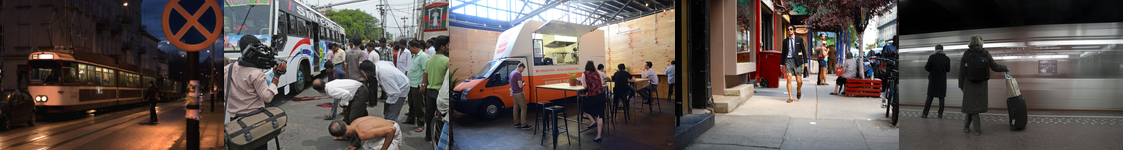

クエリ 0 の結果:
  ID: 455853798830899210, 距離: 1.0, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000188017.jpg
  ID: 455853798830899367, 距離: 0.7913016080856323, ファイルパス: ../../sample_data/WIDER_OpenData/5--Car_Accident/5_Car_Accident_Accident_5_244.jpg
  ID: 455853798830899256, 距離: 0.7448923587799072, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000544386.jpg
  ID: 455853798830899297, 距離: 0.718177318572998, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000544278.jpg
  ID: 455853798830899283, 距離: 0.6988295316696167, ファイルパス: ../../sample_data/coco_sample_datasets/sample_coco_train2017/000000188044.jpg


In [2]:
# --- 画像検索クエリ ---
query_image_path = str(random.choice(list(Path("../../sample_data/coco_sample_datasets/sample_coco_train2017/").glob("*"))))  # 検索画像のパス
query_feature = extract_feature(query_image_path)


target_height = 150


# アスペクト比を固定して、高さ200ピクセルにリサイズして表示
query_img = Image.open(query_image_path)
aspect_ratio = query_img.width / query_img.height
query_img_resized = query_img.resize((int(target_height * aspect_ratio), target_height))
query_img_resized.show()


search_params = {
    "metric_type": "COSINE",      # コサイン類似度
    "params": {"nprobe": 10}
}
results = collection.search(
    data=[query_feature.tolist()],
    anns_field="embedding",
    param=search_params,
    limit=5,
    output_fields=["id", "file_path"]  # file_pathを出力に含める
)

# 検索結果の表示
print("検索結果: 一致度：", results[0][0].distance)
hit_file_paths = [hit.entity.get("file_path") for hit in results[0]]

# 上位5件の検索結果を横並びにしてPillowで表示
imgs = [Image.open(file_path) for file_path in hit_file_paths]
resized = [img.resize((int(img.width * target_height / img.height), target_height), Image.LANCZOS) for img in imgs]
total_width = sum(img.width for img in resized)
concat_img = Image.new("RGB", (total_width, target_height))
for x, im in zip([0, *accumulate(img.width for img in resized)], resized):
    concat_img.paste(im, (x, 0))
concat_img.show()

for i, hits in enumerate(results):
    print(f"クエリ {i} の結果:")
    for hit in hits:
        print(f"  ID: {hit.id}, 距離: {hit.distance}, ファイルパス: {hit.entity.get('file_path')}")